![image](https://docs.google.com/uc?export=download&id=1Nh6vjig-ADM1RMbaHrj_GItD3O1ZW4Vr)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4206_Analisis_con_Machine_Learning/blob/main/Lab%20IV/Lab_IV.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

# **Taller No. 4**
## **Regresión Logística y Entrenamiento Desbalanceado**

## **Objetivos**
- Aprender a utilizar la regresión logística como modelo de clasificación.
- Introducción al aprendizaje por datos desbalanceados con Oversampling y Undersampling.
- Balancear datos durante el modelado a través de ponderación.

## **Nombres de los Integrantes**
- **Integrante 1**: Diego Alejandro Peña Bernal - 200814497
- **Integrante 2**: Alveiro García Niño - 202022910
- **Integrante 3**: N/A

## **Problema 1**
- Los peligros asociados a la minería de carbón son bastantes, desde enfermedades pulmonares hasta explosiones por combustión. Sin embargo, uno bastante común es el peligro sísmico. Los peligros sísmicos se resumen como la probabilidad de que un terremoto vaya a ocurrir en un área geográfica determinada. Por lo que, se le ha asignado la tarea de predecir la posibilidad de que un peligro sísmico ocurra en un área específica dadas sus condiciones geográficas.

In [ ]:
%%shell
shred -u setup_colab_general.py
wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
pip install -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
pip install -q tqdm==4.56.0
pip install -q --upgrade imbalanced-learn

In [ ]:
import setup_colab_general as setup_general
setup_general.setup_general()

  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**

In [ ]:
import numpy as np
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns
rcParams['figure.figsize'] = 14, 7

from utils import general as gen

from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, recall_score, 
                             precision_score, f1_score, confusion_matrix)
from sklearn.metrics import roc_curve

In [ ]:
data_id = "19-2ZJXc3bUY_AmpzdfneCyPWF73wsuXw"

In [ ]:
gen.download_file_from_google_drive(data_id, "data.csv", size=131)

  0%|          | 0/131 [00:00<?, ?KB/s]

In [ ]:
dataframe = pd.read_csv("data/data.csv")

In [ ]:
dataframe.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,hazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


## **Separación y Perfilamiento**
- El dataset consta de 19 columnas y 2584 filas. Las columnas y su respectivo diccionario son los siguientes:
    - seismic: Resultado de la evaluación del peligro sísmico por desplazamiento obtenida por el método sísmico. Sus variables son: a (ausencia de peligro), b (bajo riesgo), c (alto peligro) y d (estado de peligro).
    - seismoacoustic: Resultado de la evaluación de la amenaza sísmica por turnos obtenida mediante el método sismoacústico.
    - shift: Tipo de turnos w (obtención de carbón), n (turno de preparación)
    - genergy: Energía sísmica registrada dentro del cambio anterior por el geófono más activo de todos los geófonos que monitorean la pared larga.
    - gpuls: Número de pulsos registrados en el turno anterior por el geófono más activo.
    - gdenergy: Una desviación de la energía registrada dentro del turno anterior por el geófono más activo, de la energía promedio registrada durante los ocho turnos anteriores.
    - gdpuls: Una desviación de un número de pulsos registrados dentro del turno anterior por GMax del número promedio.
    - ghazard: resultado de la evaluación del peligro sísmico por turnos en el trabajo de la mina obtenido por el método sismoacústico basado en el registro proveniente de GMax solamente.
    - energy: energía total de los golpes sísmicos registrados en el turno anterior.
    - maxenergy: la energía máxima de los golpes sísmicos registrados en el turno anterior.
    - nbumps : el número de golpes sísmicos registrados en el turno anterior.
    - nbumps2 : el número de golpes sísmicos (en el rango de energía [10 ^ 2,10 ^ 3)) registrados en el turno anterior.
    - nbumps3 : el número de golpes sísmicos (en el rango de energía [10 ^ 3,10 ^ 4)) registrados en el turno anterior.
    - nbumps4 : el número de golpes sísmicos (en el rango de energía [10 ^ 4,10 ^ 5)) registrados en el turno anterior.
    - nbumps5 : el número de golpes sísmicos (en el rango de energía [10 ^ 5,10 ^ 6)) registrados en el turno anterior.
    - nbumps6 : el número de golpes sísmicos (en el rango de energía [10 ^ 6,10 ^ 7)) registrados en el turno anterior.
    - nbumps7 : el número de golpes sísmicos (en el rango de energía [10 ^ 7,10 ^ 8)) registrados en el turno anterior.
    - nbumps89 : el número de golpes sísmicos (en el rango de energía [10 ^ 8,10 ^ 10)) registrados en el turno anterior.


In [ ]:
X = dataframe.drop("class", axis=1)
y = dataframe["class"]

In [ ]:
stratified_splitter = StratifiedShuffleSplit(test_size=0.3, random_state=1234)

In [ ]:
for full_train_index, test_index in stratified_splitter.split(X, y):
    full_X_train, full_y_train = X.iloc[full_train_index], y.iloc[full_train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

In [ ]:
stratified_splitter = StratifiedShuffleSplit(test_size=0.3, random_state=5678)

In [ ]:
for train_index, val_index in stratified_splitter.split(full_X_train, full_y_train):
    X_train, y_train = full_X_train.iloc[train_index], full_y_train.iloc[train_index]
    X_val, y_val = full_X_train.iloc[val_index], full_y_train.iloc[val_index]

In [ ]:
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
pandas_profiling.ProfileReport(X_train, minimal=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 0 to 1264
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   seismic         1265 non-null   object
 1   seismoacoustic  1265 non-null   object
 2   shift           1265 non-null   object
 3   genergy         1265 non-null   int64 
 4   gpuls           1265 non-null   int64 
 5   gdenergy        1265 non-null   int64 
 6   gdpuls          1265 non-null   int64 
 7   hazard          1265 non-null   object
 8   nbumps          1265 non-null   int64 
 9   nbumps2         1265 non-null   int64 
 10  nbumps3         1265 non-null   int64 
 11  nbumps4         1265 non-null   int64 
 12  nbumps5         1265 non-null   int64 
 13  nbumps6         1265 non-null   int64 
 14  nbumps7         1265 non-null   int64 
 15  nbumps89        1265 non-null   int64 
 16  energy          1265 non-null   int64 
 17  maxenergy       1265 non-null   int64 
dtypes: int64

In [ ]:
X_train.describe()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy
count,1.265000e+03,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.0,1265.0,1265.0,1265.000000,1265.000000
mean,8.511620e+04,527.474308,13.513834,4.777075,0.858498,0.381818,0.401581,0.069565,0.005534,0.0,0.0,0.0,5466.166008,4738.023715
std,1.995497e+05,520.914791,79.270866,61.269205,1.340600,0.782817,0.771320,0.283901,0.074211,0.0,0.0,0.0,22293.923576,21089.557022
min,4.300000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
25%,1.180000e+04,189.000000,-38.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
50%,2.546000e+04,381.000000,-5.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
75%,5.141000e+04,660.000000,41.000000,29.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,3000.000000,2000.000000
max,1.661100e+06,3510.000000,681.000000,367.000000,9.000000,8.000000,5.000000,3.000000,1.000000,0.0,0.0,0.0,303000.000000,300000.000000


In [ ]:
y_train.unique()

array([0, 1])

In [ ]:
y_train.mean(), 1 - y_train.mean()

(0.06561264822134387, 0.9343873517786562)

In [ ]:
y_val.mean(), 1 - y_val.mean()

(0.06629834254143646, 0.9337016574585635)

In [ ]:
y_test.mean(), 1 - y_test.mean()

(0.06572164948453608, 0.9342783505154639)

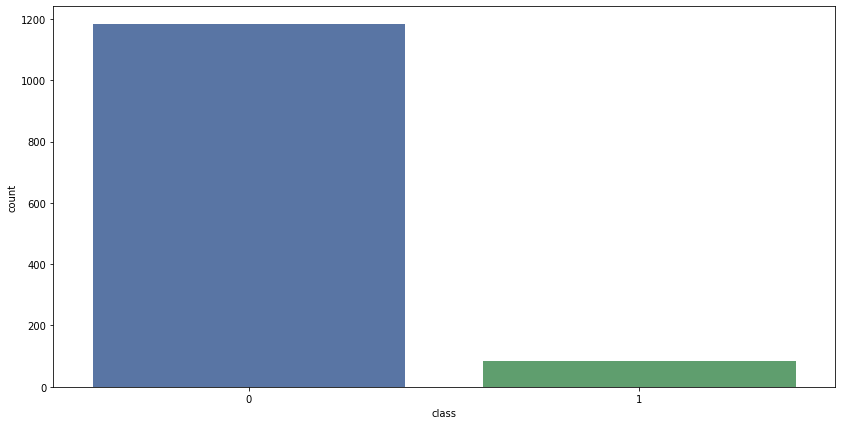

In [ ]:
sns.countplot(x=y_train)
plt.show()

## **Procesamiento y Limpieza**

In [ ]:
def pipeline(data):
    data_copy = data.copy()
    label_encoder = LabelEncoder()

    for col_name, col in data_copy.iteritems():
        if col.dtype == "object":
            data_copy[col_name] = label_encoder.fit_transform(col)

    variance_threshold = VarianceThreshold()
    data_copy = variance_threshold.fit_transform(data_copy)
    
    min_max_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()

    negative_indexes = list()
    positive_indexes = list()
    for col_index in range(data_copy[0].size):
        if np.unique(data_copy[:, col_index]).size >= 20:
            if data_copy[:, col_index].min() < 0:
                negative_indexes.append(col_index)
            else:
                positive_indexes.append(col_index)
    data_copy[:, negative_indexes] = standard_scaler.fit_transform(
        data_copy[:, negative_indexes]
    )
    data_copy[:, positive_indexes] = min_max_scaler.fit_transform(
        data_copy[:, positive_indexes]
    )
    return data_copy

In [ ]:
X_train_transformed = pipeline(X_train)

In [ ]:
X_train.shape

(1265, 18)

In [ ]:
X_train_transformed.shape

(1265, 15)

## **Modelado**
### **Sin Remuestreo**

In [ ]:
log_reg = LogisticRegression().fit(X_train_transformed, y_train)

In [ ]:
X_val_transformed = pipeline(X_val)

In [ ]:
y_pred = log_reg.predict(X_val_transformed)

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       507
           1       0.00      0.00      0.00        36

    accuracy                           0.93       543
   macro avg       0.47      0.50      0.48       543
weighted avg       0.87      0.93      0.90       543



In [ ]:
f1_score(y_val, y_pred)

0.0

### **Oversampling**
- SMOTE

In [ ]:
resampler = SMOTE(random_state=1234, sampling_strategy=0.5)

In [ ]:
X_train_resampled, y_train_resampled = resampler.fit_resample(
    X_train_transformed, y_train
)

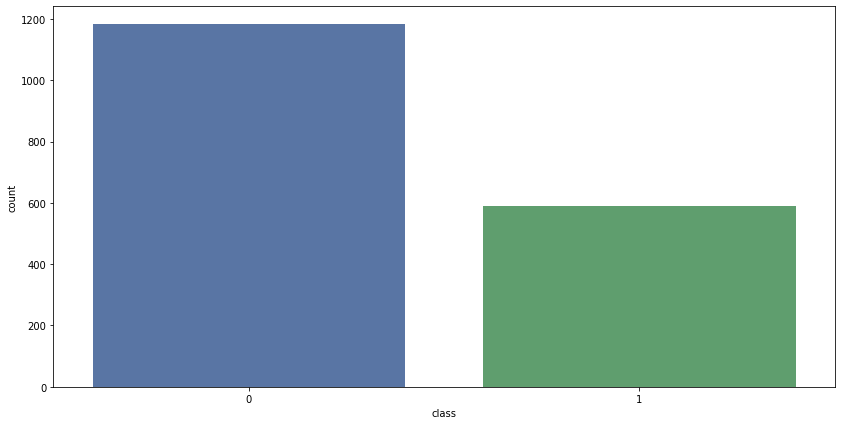

In [ ]:
sns.countplot(x=y_train_resampled)
plt.show()

In [ ]:
X_train_resampled.shape

(1773, 15)

In [ ]:
y_train_resampled.shape

(1773,)

In [ ]:
log_reg = LogisticRegression().fit(X_train_resampled, y_train_resampled)

In [ ]:
X_val_resampled, y_val_resampled = resampler.fit_resample(X_val_transformed, y_val)

In [ ]:
y_pred = log_reg.predict(X_val_transformed)

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       507
           1       0.26      0.42      0.32        36

    accuracy                           0.88       543
   macro avg       0.61      0.67      0.63       543
weighted avg       0.91      0.88      0.90       543



In [ ]:
f1_score(y_val, y_pred)

0.3225806451612903

### **Subsampling**

In [ ]:
resampler = RandomUnderSampler(random_state=1234, sampling_strategy=0.3)

In [ ]:
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_transformed, y_train)

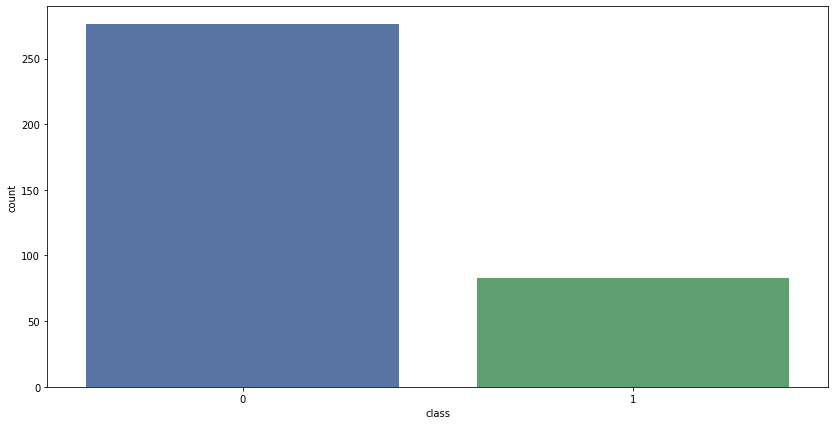

In [ ]:
sns.countplot(x=y_train_resampled)
plt.show()

In [ ]:
X_train_resampled.shape

(359, 15)

In [ ]:
y_train_resampled.shape

(359,)

In [ ]:
log_reg = LogisticRegression().fit(X_train_resampled, y_train_resampled)

In [ ]:
y_pred = log_reg.predict(X_val_transformed)

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       507
           1       0.29      0.33      0.31        36

    accuracy                           0.90       543
   macro avg       0.62      0.64      0.63       543
weighted avg       0.91      0.90      0.91       543



In [ ]:
f1_score(y_val, y_pred)

0.3116883116883117

### **Balanceo en el Modelado**

In [ ]:
LogisticRegression?

In [ ]:
log_reg = LogisticRegression(class_weight="balanced").fit(
    X_train_transformed, y_train
)

In [ ]:
y_pred = log_reg.predict(X_val_transformed)

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       507
           1       0.16      0.75      0.26        36

    accuracy                           0.72       543
   macro avg       0.57      0.73      0.54       543
weighted avg       0.92      0.72      0.79       543



In [ ]:
f1_score(y_val, y_pred)

0.2608695652173913

## **Validación**

In [ ]:
resampler = SMOTE(random_state=1234, sampling_strategy=0.5)

In [ ]:
X_train_resampled, y_train_resampled = resampler.fit_resample(
    X_train_transformed, y_train
)

In [ ]:
X_train_resampled.shape

(1773, 15)

In [ ]:
log_reg = LogisticRegression().fit(X_train_resampled, y_train_resampled)

In [ ]:
X_test_transformed = pipeline(X_test)

In [ ]:
y_pred = log_reg.predict(X_test_transformed)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       725
           1       0.23      0.35      0.27        51

    accuracy                           0.88       776
   macro avg       0.59      0.63      0.60       776
weighted avg       0.90      0.88      0.89       776



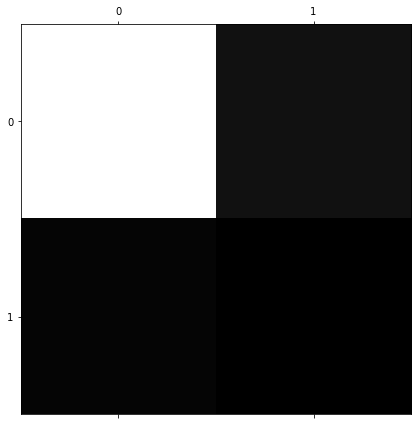

In [ ]:
plt.matshow(confusion_matrix(y_test, y_pred), cmap="gray");

In [ ]:
f1_score(y_test, y_pred)

0.2748091603053435

# Ejercicio Taller 4

## **Enunciado**
- El infarto de miocardio está estrechamente relacionado con factores de estrés crónico y una nutrición irregular y no siempre equilibrada. El curso de la enfermedad en pacientes con infarto de miocardio es diferente. Puede ocurrir sin complicaciones o con complicaciones que no empeoran el pronóstico a largo plazo. Pero también, aproximadamente la mitad de los pacientes en los períodos agudo y subagudo tienen complicaciones que conducen al empeoramiento de la enfermedad e incluso a la muerte. En muchos casos un especialista experimentado no siempre puede prever el desarrollo de estas complicaciones. En este sentido, construir modelos con aprendizaje automático que ayuden a predecir las complicaciones del infarto de miocardio puede apoyar la toma decisiones en cuanto a las medidas preventivas a aplicar. El conjunto de datos a utilizar para el estudio se encuentra en el siguiente [enlace](https://drive.google.com/file/d/1wMqUCQ3_q1InDS0coW-s6J5Rct8WK9iQ/view?usp=sharing).
Las variables de las columnas 113 a 124 representan posibles complicaciones. En esta etapa inicial del estudio los expertos se quieren enfocar en la complicación relacionada con “Falla de corazón crónica” (Chronic heart failure, ZSN). Además, han hecho sugerencias sobre cómo tratar las ausencias. Recomiendan eliminar los atributos con más de 10% de ausencias en primera instancia. Luego, aplicar una eliminación de registros.
Construya este modelo de predicción utilizando una máquina de vectores de soporte. Como los datos no están balanceadas, aplique las tres técnicas vistas en este laboratorio y compare los resultados. Finalmente, para los modelos resultantes de estas tres técnicas, construya una curva ROC para cada uno y grafique dentro de la misma imagen.

## 1. Configuración de ambiente

In [112]:
%%shell
shred -u setup_colab_general.py
wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
pip install -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
pip install -q tqdm==4.56.0
pip install -q --upgrade imbalanced-learn

In [113]:
import setup_colab_general as setup_general
setup_general.setup_general()

  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


### Librerías necesarias para el análisis

In [114]:
# Importing the libraries that will be used
import pandas as pd
import numpy as np
import sys

#!pip uninstall pandas-profiling
#!pip install pandas-profiling
import pandas_profiling

import time 
from utils import general as gen

# Data Modeling Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OrdinalEncoder

# Support vector machine classification library
from sklearn.svm import SVC

#from sklearn.neighbors import NearestNeighbors
#from sklearn.neighbors import KNeighborsRegressor

# Data visualization libraries
import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns
rcParams['figure.figsize'] = 14, 7

#Save the model
from joblib import dump, load

# Oversampling and undersampling
from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, recall_score, 
                             precision_score, f1_score, confusion_matrix)
from sklearn.metrics import roc_curve
print("Libraries imported")

Libraries imported


## 2. Entendimiento y perfilamiento de los datos

Se cargan los datos a ser analizados.

In [115]:
data_id = "1E41up23dp32ZHUbI8vir1hCQbEKk2GEA"

In [116]:
gen.download_file_from_google_drive(data_id, "Myocardial infarction complications Database.csv", size=438)

  0%|          | 0/438 [00:00<?, ?KB/s]

In [117]:
data = pd.read_csv("data/Myocardial infarction complications Database.csv")

In [118]:
data.head()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_KBRIG,D_AD_KBRIG,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,...,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,KFK_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NA_KB,NOT_NA_KB,LID_KB,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,1,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,180.0,100.0,0.0,0.0,...,0.0,138.0,NaN,NaN,NaN,8.0,16.0,4.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,120.0,90.0,0.0,0.0,...,0.0,132.0,0.38,0.18,NaN,7.8,3.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,100.0,180.0,100.0,0.0,0.0,...,0.0,132.0,0.30,0.11,NaN,10.8,NaN,3.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,120.0,70.0,0.0,0.0,...,0.0,146.0,0.75,0.37,NaN,NaN,NaN,2.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0
4,5,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190.0,100.0,160.0,90.0,0.0,0.0,...,0.0,132.0,0.45,0.22,NaN,8.3,NaN,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0


### Separación y perfilamiento de los datos

El dataset consta de 124 columnas y 1700 filas. 
Las columnas 113 a 124 que representan posibles complicaciones son:

* FIBR_PREDS
* PREDS_TAH
* JELUD_TAH
* FIBR_JELUD
* A_V_BLOK
* OTEK_LANC
* RAZRIV
* DRESSLER
* ZSN
* REC_IM
* P_IM_STEN
* LET_IS

Dado que los expertos se quieren enfocar en la complicación relacionada con “Falla de corazón crónica” (Chronic heart failure, ZSN), se verificará la información contenida por esta variable.

In [119]:
data['ZSN']

0       0
1       0
2       0
3       1
4       0
       ..
1695    0
1696    0
1697    0
1698    0
1699    0
Name: ZSN, Length: 1700, dtype: int64

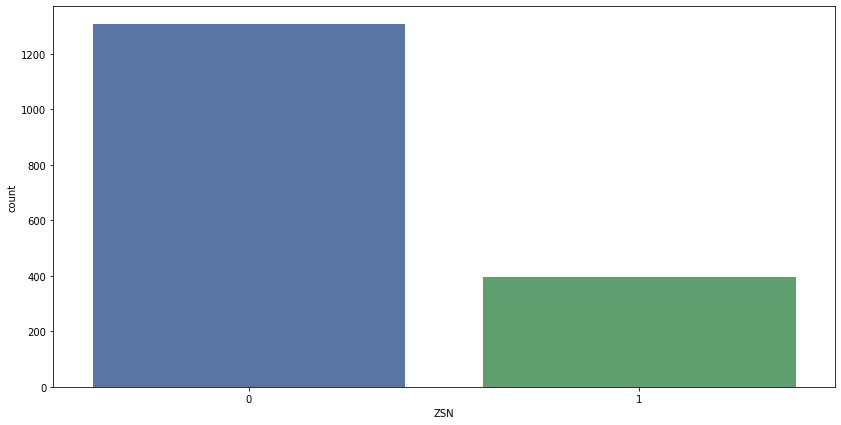

In [120]:
sns.countplot(x=data["ZSN"])
plt.show()

Se ha verificado que la variable ZSN es binaria, tomando únicamente los valores de "0" y "1".
Esta será la variable target para nuestro análisis.

In [121]:
X = data.drop("ZSN", axis=1)
y = data["ZSN"]

In [122]:
stratified_splitter = StratifiedShuffleSplit(test_size=0.3, random_state=1234)

for full_train_index, test_index in stratified_splitter.split(X, y):
    full_X_train, full_y_train = X.iloc[full_train_index], y.iloc[full_train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

In [123]:
stratified_splitter = StratifiedShuffleSplit(test_size=0.3, random_state=5678)

for train_index, val_index in stratified_splitter.split(full_X_train, full_y_train):
    X_train, y_train = full_X_train.iloc[train_index], full_y_train.iloc[train_index]
    X_val, y_val = full_X_train.iloc[val_index], full_y_train.iloc[val_index]

In [124]:
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [125]:
pandas_profiling.ProfileReport(X_train, minimal=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Summarize dataset:   0%|          | 0/131 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [126]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Columns: 123 entries, ID to LET_IS
dtypes: float64(110), int64(13)
memory usage: 800.6 KB


In [127]:
X_train.describe()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_KBRIG,D_AD_KBRIG,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,...,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,KFK_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NA_KB,NOT_NA_KB,LID_KB,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,REC_IM,P_IM_STEN,LET_IS
count,833.000000,830.000000,833.000000,833.000000,776.000000,796.000000,812.000000,38.000000,830.000000,830.000000,700.000000,811.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.0,824.000000,825.000000,825.000000,825.000000,825.0,825.000000,825.000000,825.000000,828.000000,828.000000,828.000000,832.000000,832.000000,832.000000,832.000000,832.000000,307.000000,307.000000,704.000000,704.000000,826.000000,825.000000,...,648.000000,648.000000,648.000000,693.000000,692.000000,1.0,775.000000,740.000000,762.000000,827.000000,783.000000,773.000000,499.000000,484.000000,487.000000,828.000000,830.000000,781.000000,769.000000,827.000000,779.000000,768.000000,828.000000,827.000000,827.000000,822.000000,823.000000,824.000000,824.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000
mean,861.445378,61.983133,0.615846,0.559424,2.310567,1.201005,1.155172,0.289474,1.431325,0.031325,3.341429,0.202219,0.025485,0.004854,0.009709,0.014563,0.014563,0.0,0.003641,0.002424,0.003636,0.003636,0.0,0.002424,0.002424,0.001212,0.135266,0.021739,0.007246,0.072115,0.070913,0.026442,0.006010,0.014423,139.136808,82.263844,135.397727,83.018466,0.071429,0.019394,...,4.188426,0.024691,136.671296,0.481371,0.265289,3.6,8.894955,13.636486,4.595801,0.327690,0.136654,0.084088,0.579158,0.690083,0.383984,0.103865,0.468675,0.087068,0.054616,0.362757,0.133504,0.095052,0.293478,0.137848,0.652963,0.734793,0.741191,0.021845,0.208738,0.090036,0.007203,0.028812,0.040816,0.037215,0.099640,0.033613,0.049220,0.099640,0.092437,0.422569
std,485.613071,11.013960,0.486687,0.834437,2.455843,1.057967,0.802622,0.459606,1.103556,0.174300,3.094459,0.669287,0.157690,0.069546,0.098113,0.119869,0.119869,0.0,0.060265,0.049207,0.060229,0.060229,0.0,0.049207,0.049207,0.034816,0.342214,0.145919,0.084868,0.258834,0.256835,0.160543,0.077335,0.119299,35.088416,19.033135,30.809113,17.738850,0.257695,0.137989,...,0.784651,0.155303,6.456966,0.376710,0.207078,NaN,3.424793,11.911788,2.852831,0.649265,0.423688,0.328945,0.494190,0.462938,0.486854,0.305269,0.770917,0.339833,0.264442,0.675741,0.442178,0.375351,0.455631,0.344949,0.476316,0.441712,0.438247,0.146265,0.406653,0.286405,0.084614,0.167377,0.197983,0.189402,0.299699,0.180340,0.216456,0.299699,0.289816,1.271571
min,3.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.300000,0.000000,117.000000,0.050000,0.040000,3.6,2.100000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,448.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [128]:
y_train.unique()

array([0, 1])

In [129]:
y_train.mean(), 1 - y_train.mean()

(0.23169267707082833, 0.7683073229291717)

In [130]:
y_val.mean(), 1 - y_val.mean()

(0.23249299719887956, 0.7675070028011204)

In [131]:
y_test.mean(), 1 - y_test.mean()

(0.23137254901960785, 0.7686274509803921)

## 3. Procesamiento y limpieza

Los datos se procesaran de acuerdo a la información visualizada y a las sugerencias de los expertos.

Las sugerencias sobre cómo tratar las ausencias son:

* Eliminar los atributos con más de 10% de ausencias.
* Aplicar una eliminación de registros.

Se observó que las siguientes variables tienen un valor constante, por lo que se dice no aportarán información al modelo y por tanto se eliminarán:

* nr_07: Valor constante de "0.0".
* np_07: Valor constante de "0.0".
* ritm_ecg_p_06: Valor constante de "0.0".
* KFK_BLOOD: Valor constante de "3.6".

De acuerdo a las sugerencias de los expertos, se deben eliminar los siguiente atributos que tienen más de 10% de ausencias:

* IBS_NASL: 795 (95.4%) valores faltantes
* DLIT_AG: 133 (16.0%) valores faltantes
* S_AD_KBRIG: 526 (63.1%) valores faltantes	
* D_AD_KBRIG: 526 (63.1%) valores faltantes	
* S_AD_ORIT: 129 (15.5%) valores faltantes	
* D_AD_ORIT: 129 (15.5%) valores faltantes
* GIPO_K: 184 (22.1%) valores faltantes	
* K_BLOOD: 185 (22.2%) valores faltantes	
* GIPER_NA: 185 (22.2%) valores faltantes	
* NA_BLOOD: 185 (22.2%) valores faltantes	
* ALT_BLOOD: 140 (16.8%) valores faltantes	
* AST_BLOOD: 141 (16.9%) valores faltantes	
* KFK_BLOOD: 832 (99.9%) valores faltantes
* ROE: 93 (11.2%) valores faltantes
* NA_KB: 334 (40.1%) valores faltantes	
* NOT_NA_KB: 349 (41.9%) valores faltantes	
* LID_KB: 346 (41.5%) valores faltantes

Adicionalmente se removeran las columans 113 a 124 que corresponden a complicaciones o variables target para otro análisis, exceptuando la variable ZSN que es nuestra variable target:

* FIBR_PREDS
* PREDS_TAH
* JELUD_TAH
* FIBR_JELUD
* A_V_BLOK
* OTEK_LANC
* RAZRIV
* DRESSLER
* ZSN
* REC_IM
* P_IM_STEN
* LET_IS

Por otra parte, la variable ID tiene un valor únicao para cada registro, por lo que se remueve del dataset.



In [132]:
def pipeline(X_data, y_data):
    data_copy = X_data.copy()
    data_copy_y = y_data.copy()

    # Removing columns 113 to 124 except the ZSN column
    data_copy.drop(['FIBR_PREDS',
                    'PREDS_TAH',
                    'JELUD_TAH',
                    'FIBR_JELUD',
                    'A_V_BLOK',
                    'OTEK_LANC',
                    'RAZRIV',
                    'DRESSLER',
                    'REC_IM',
                    'P_IM_STEN',
                    'LET_IS'], axis=1, inplace=True, errors= 'ignore')

    # Removing atributes whith more than 10% of missings values
    data_copy.drop(['IBS_NASL',
                    'DLIT_AG',
                    'S_AD_KBRIG',
                    'D_AD_KBRIG',
                    'S_AD_ORIT',
                    'D_AD_ORIT',
                    'GIPO_K',
                    'K_BLOOD',
                    'GIPER_NA',
                    'NA_BLOOD',
                    'ALT_BLOOD',
                    'AST_BLOOD',
                    'KFK_BLOOD',
                    'ROE',
                    'NA_KB',
                    'NOT_NA_KB',
                    'LID_KB'], axis=1, inplace=True, errors= 'ignore')
    
    # Removing atributes with constant value
    data_copy.drop(['nr_07',
                    'np_07',
                    'ritm_ecg_p_06'], axis=1, inplace=True, errors= 'ignore')

    # Removing records
    data_copy = data_copy.dropna(axis=0, how='any')
    # Removing the data in data_copy_y using the indexes of data_copy
    data_copy_y = data_copy_y.loc[data_copy.index]
    
    # Removing the low variance features
    #variance_threshold = VarianceThreshold()
    #data_copy = variance_threshold.fit_transform(data_copy)

    # Scaling data
    standard_scaler = StandardScaler()
    data_copy = standard_scaler.fit_transform(data_copy)

    return data_copy, data_copy_y

In [133]:
X_train_transformed, y_train = pipeline(X_train, y_train)

In [134]:
X_val_transformed, y_val = pipeline(X_val, y_val)

Viendo los datos iniciales antes de la limpieza:

In [135]:
X_train.shape

(833, 123)

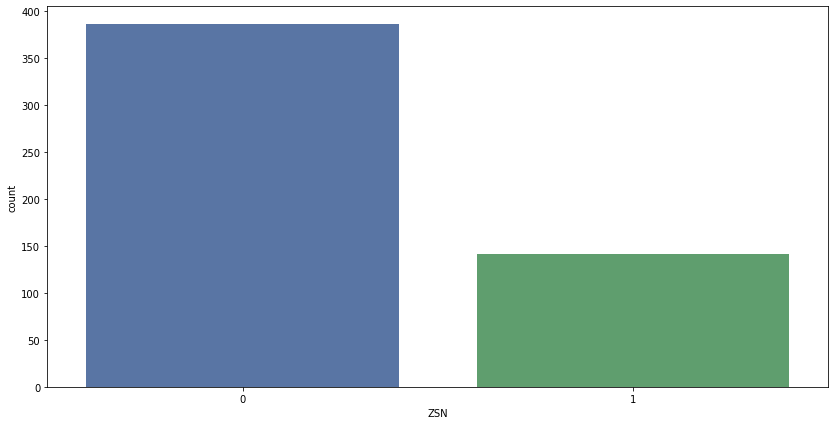

In [136]:
sns.countplot(x=y_train)
plt.show()

Viendo los datos después de la limpieza:

In [137]:
X_train_transformed.shape

(527, 92)

Verificando que los registros removidos en X también se hayan removido en y:

In [138]:
y_train.shape

(527,)

## 4. Modelado

Modelo de predicción utilizando una máquina de vectores de soporte. Teniendo en cuenta que la variable objetivo se encuentra muy desbalanceada como se evidenció anteriormente, se procede a balancear los datos para poder aplicar el modelo.

### Oversampling

Se usa SMOTE para realizar un sobre-muestreo.

In [139]:
resampler = SMOTE(random_state=1234, sampling_strategy=0.5)

In [140]:
X_train_resampled, y_train_resampled = resampler.fit_resample(
    X_train_transformed, y_train
)

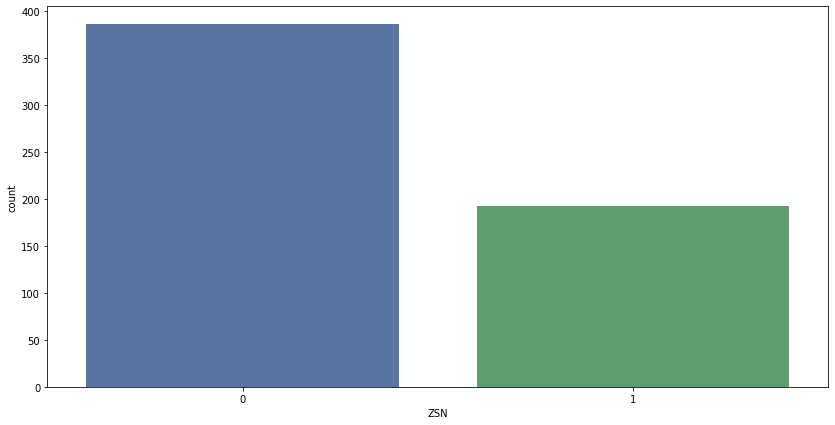

In [141]:
sns.countplot(x=y_train_resampled)
plt.show()

In [142]:
X_train_resampled.shape

(579, 92)

In [143]:
y_train_resampled.shape

(579,)

In [144]:
# Gridsearch function

def grid_search_for_svc(X_data, y_data, class_weight=False):

    estimators = [
                    ('svc', SVC()),
                  ]

    if class_weight:
          params = [{'svc__kernel': ['rbf', 'linear', 'poly'],
            'svc__C': [1e3],
            'svc__gamma': [0.1], 
            'svc__degree': [2],
            'svc__class_weight': ["balanced"]}]
    else:
      params = [{'svc__kernel': ['rbf', 'linear', 'poly'],
            'svc__C': [1e3],
            'svc__gamma': [0.1], 
            'svc__degree': [2]}]

    pipe = Pipeline(estimators)

    gs_svc = GridSearchCV(pipe,
                          param_grid=params,
                          scoring='roc_auc',
                          cv=5)

    gs_svc.fit(X_data, y_data)

    display(gs_svc.best_params_)



In [145]:
# Fit regression model
#svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)

grid_search_for_svc(X_train_resampled, y_train_resampled)



{'svc__C': 1000.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

Teniendo en cuenta que se tuvo un resultado se hace el llamado de la SVC incluyendo los mejores parametros y adicionalmente incluyendo el parametro de probabilidad en true, lo cual es necesario para poder generar la grafica ROC (No se incluye durante la etapa de gridsearch por que SVC internamente genera 5 foldings para calcular las probabilidades, lo cual puede incrementar considerablemente el tiempo de procesamiento )

In [146]:
svm_rbf = SVC(kernel='rbf', C=1e3, gamma=0.1, degree=2, probability=True)
# svm_lin = SVC(kernel='linear', C=1e3, probability=True)
# svm_poly = SVC(kernel='poly', C=1e3, degree=2, probability=True)

svm_rbf_fit = svm_rbf.fit(X_train_resampled, y_train_resampled)
# svm_lin_fit = svm_lin.fit(X_train_resampled, y_train_resampled)
# svm_poly_fit = svm_poly.fit(X_train_resampled, y_train_resampled)

In [147]:
X_val_resampled, y_val_resampled = resampler.fit_resample(X_val_transformed, y_val)

In [148]:
y_pred_rbf = svm_rbf_fit.predict(X_val_transformed)
# y_pred_lin = svm_lin_fit.predict(X_val_transformed)
# y_pred_poly = svm_poly_fit.predict(X_val_transformed)

In [149]:
print(classification_report(y_val, y_pred_rbf))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87       184
           1       0.40      0.04      0.07        53

    accuracy                           0.77       237
   macro avg       0.59      0.51      0.47       237
weighted avg       0.70      0.77      0.69       237



In [150]:
f1_score(y_val, y_pred_rbf)

0.06896551724137931

In [151]:
y_pred_rbf_prob = svm_rbf_fit.predict_proba(X_val_transformed)[:,1]
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_val, y_pred_rbf_prob)


### Subsampling

Realizando un submuestreo a los datos.

In [152]:
resampler = RandomUnderSampler(random_state=1234, sampling_strategy=0.5)

In [153]:
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_transformed, y_train)

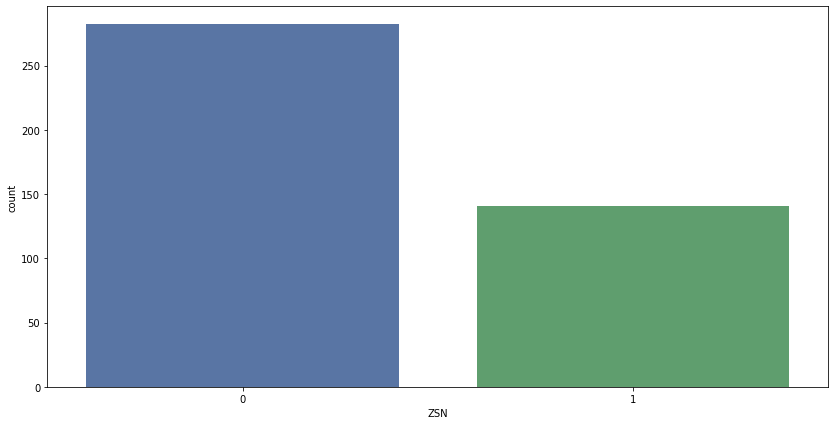

In [154]:
sns.countplot(x=y_train_resampled)
plt.show()

In [155]:
X_train_resampled.shape

(423, 92)

In [156]:
y_train_resampled.shape

(423,)

In [157]:
grid_search_for_svc(X_train_resampled, y_train_resampled)

{'svc__C': 1000.0,
 'svc__degree': 2,
 'svc__gamma': 0.1,
 'svc__kernel': 'linear'}

Igual que en el caso anterior se hace el llamado del algoritmo haciendo uso de los parametros seleccionados y adicionando el parametro de probability en true 

In [158]:
# Fit regression model
##svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)

# svm_rbf = SVC(kernel='rbf', C=1e3, gamma=0.1, probability=True)
svm_lin = SVC(kernel='linear', C=1e3, gamma=0.1, degree=2, probability=True)
# svm_poly = SVC(kernel='poly', C=1e3, degree=2, probability=True)

# svm_rbf_fit = svm_rbf.fit(X_train_resampled, y_train_resampled)
svm_lin_fit1 = svm_lin.fit(X_train_resampled, y_train_resampled)
# svm_poly_fit = svm_poly.fit(X_train_resampled, y_train_resampled)

In [159]:
X_val_resampled, y_val_resampled = resampler.fit_resample(X_val_transformed, y_val)

In [160]:
# y_pred_rbf = svm_rbf_fit.predict(X_val_transformed)
y_pred_lin = svm_lin_fit1.predict(X_val_transformed)
# y_pred_poly = svm_poly_fit.predict(X_val_transformed)

In [161]:
print(classification_report(y_val, y_pred_lin))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       184
           1       0.36      0.34      0.35        53

    accuracy                           0.72       237
   macro avg       0.59      0.58      0.58       237
weighted avg       0.71      0.72      0.71       237



In [162]:
f1_score(y_val, y_pred_lin)

0.3495145631067961

In [163]:
y_pred_lin_prob = svm_lin_fit1.predict_proba(X_val_transformed)[:,1]
fpr_sub_sampling, tpr_sub_sampling, thresholds_sub_sampling = roc_curve(y_val, y_pred_lin_prob)


### Balanceo en el Modelado

Se realiza un balanceo de los datos usando el atributo "class_weight" the SVC

In [164]:
SVC?

En este caso, se hace uso del parametro class_weight en true, el cual fue incluido en la funcion de grid search para que la busqueda de parámetros se hagan incluyendo ese parámetro a su vez con datos balanceados 

In [165]:
grid_search_for_svc(X_train_transformed, y_train, class_weight=True)

{'svc__C': 1000.0,
 'svc__class_weight': 'balanced',
 'svc__degree': 2,
 'svc__gamma': 0.1,
 'svc__kernel': 'linear'}

In [166]:
# Using the "class_weight" parameter to balance the data
# svm_rbf = SVC(kernel='rbf', C=1e3, gamma=0.1, class_weight="balanced", probability=True)
svm_lin = SVC(kernel='linear', C=1e3, gamma=0.1, degree=2, class_weight="balanced", probability=True)
# svm_poly = SVC(kernel='poly', C=1e3, degree=2, class_weight="balanced", probability=True)

# svm_rbf_fit = svm_rbf.fit(X_train_transformed, y_train)
svm_lin_fit2 = svm_lin.fit(X_train_transformed, y_train)
# svm_poly_fit = svm_poly.fit(X_train_transformed, y_train)

In [167]:
# y_pred_rbf = svm_rbf_fit.predict(X_val_transformed)
y_pred_lin = svm_lin_fit2.predict(X_val_transformed)
# y_pred_poly = svm_poly_fit.predict(X_val_transformed)

In [168]:
print(classification_report(y_val, y_pred_lin))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       184
           1       0.33      0.51      0.40        53

    accuracy                           0.65       237
   macro avg       0.58      0.60      0.58       237
weighted avg       0.72      0.65      0.68       237



In [169]:
f1_score(y_val, y_pred_lin)

0.3970588235294118

In [170]:
y_pred_lin_prob = svm_lin_fit2.predict_proba(X_val_transformed)[:,1]
fpr_model, tpr_model, thresholds_model = roc_curve(y_val, y_pred_lin_prob)

Comparamos la curva ROC obtenida para cada modelado realizado:

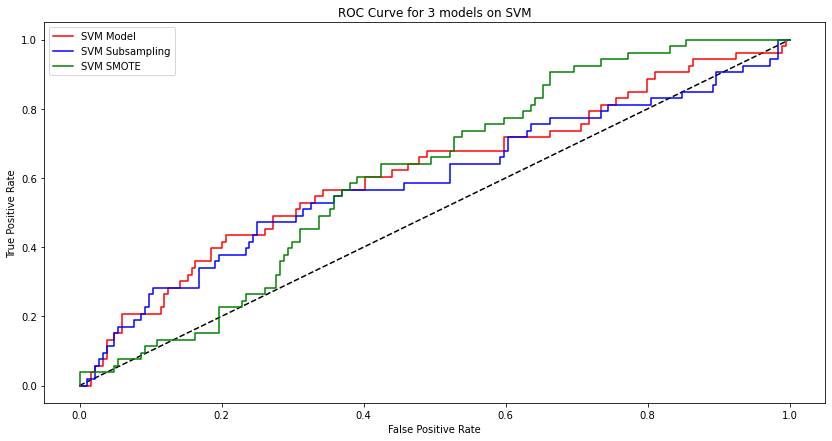

In [171]:
# Creating ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_model, tpr_model, label='SVM Model', color='r')
plt.plot(fpr_sub_sampling, tpr_sub_sampling, label='SVM Subsampling', color='b')
plt.plot(fpr_smote, tpr_smote, label='SVM SMOTE', color='g')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 3 models on SVM')
plt.legend()
plt.show();

## 5. Prueba del modelo

Teniendo en cuenta los resultados obtenidos usando las diferentes técnicas, se procede a validar el modelo que obtuvo mejor desempeño con los datos de prueba.

In [172]:
X_test_transformed, y_test = pipeline(X_test, y_test)

In [173]:
y_pred = svm_lin_fit2.predict(X_test_transformed)

In [174]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.69      0.75       236
           1       0.34      0.50      0.40        74

    accuracy                           0.65       310
   macro avg       0.58      0.60      0.58       310
weighted avg       0.70      0.65      0.67       310



In [175]:
f1_score(y_test, y_pred)

0.4043715846994536

### Curva ROC sobre datos test

In [176]:
# SMOTE
y_pred_rbf_prob = svm_rbf_fit.predict_proba(X_test_transformed)[:,1]
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_pred_rbf_prob)

In [177]:
# Subsampling
y_pred_lin1_prob = svm_lin_fit1.predict_proba(X_test_transformed)[:,1]
fpr_sub_sampling, tpr_sub_sampling, thresholds_sub_sampling = roc_curve(y_test, y_pred_lin1_prob)

In [178]:
# Based on modeling
y_pred_lin2_prob = svm_lin_fit2.predict_proba(X_test_transformed)[:,1]
fpr_model, tpr_model, thresholds_model = roc_curve(y_test, y_pred_lin2_prob)

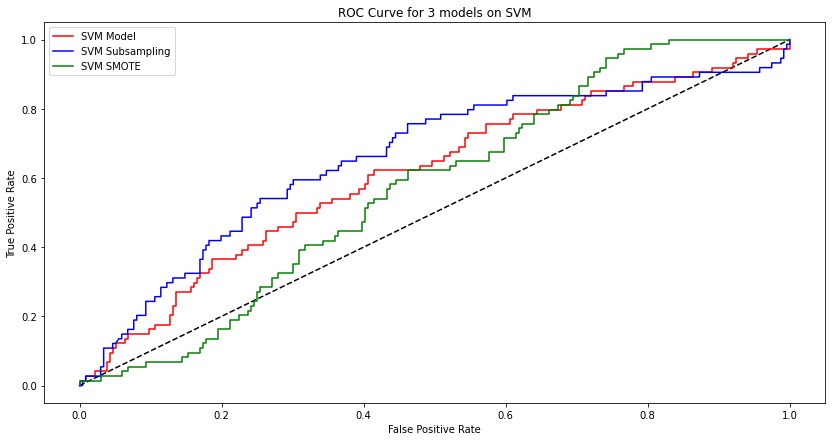

In [179]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_model, tpr_model, label='SVM Model', color='r')
plt.plot(fpr_sub_sampling, tpr_sub_sampling, label='SVM Subsampling', color='b')
plt.plot(fpr_smote, tpr_smote, label='SVM SMOTE', color='g')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 3 models on SVM')
plt.legend()
plt.show();